
## Task: based on data from the account of one of MapMyRun users:

     1. identify the most common distance of a runner
     2. visualize the average time in specific periods
     3. show the 10 best results

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import time
import matplotlib.pyplot as plt
from matplotlib import dates
import matplotlib.dates as mdates
import seaborn as sns


# Since the structure of the csv file is known, we create a dictionary with the necessary columns;
# and the required data type.

columns = {'Workout Date': str,
           'Activity Type': str,
           'Calories Burned (kCal)': int,
           'Distance (km)': float,
           'Workout Time (seconds)': int,
           'Avg Pace (min/km)': float,
           'Avg Speed (km/h)': float,
          }

column_list = list(columns.keys())

# read source data
training = pd.read_csv("files/training.csv", usecols=column_list, dtype=columns)

training.head()

,Workout Date,Activity Type,Calories Burned (kCal),Distance (km),Workout Time (seconds),Avg Pace (min/km),Avg Speed (km/h)
0,"Oct. 5, 2023",Run,283,4.012078,1062,4.411680,13.600260
1,"Oct. 5, 2023",Bike Ride,190,6.301403,1224,3.237375,18.533527
2,"Oct. 5, 2023",Bike Ride,171,5.586130,934,2.786663,21.531092
3,"Oct. 4, 2023",Bike Ride,277,9.194054,1673,3.032757,19.783988
4,"Oct. 4, 2023",Bike Ride,167,5.500400,935,2.833130,21.178001


In [2]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Workout Date            1246 non-null   object 
 1   Activity Type           1246 non-null   object 
 2   Calories Burned (kCal)  1246 non-null   int64  
 3   Distance (km)           1246 non-null   float64
 4   Workout Time (seconds)  1246 non-null   int64  
 5   Avg Pace (min/km)       1246 non-null   float64
 6   Avg Speed (km/h)        1246 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 68.3+ KB


### 1. finding the most common distance of a runner:

In [3]:
df = training.copy()

# limit floats to two decimals
df = df.round(2)

# what are the types of activities?
df['Activity Type'].unique()

array(['Run', 'Bike Ride', 'Walk', 'Winter Sport / Activity', 'Generic'],
      dtype=object)

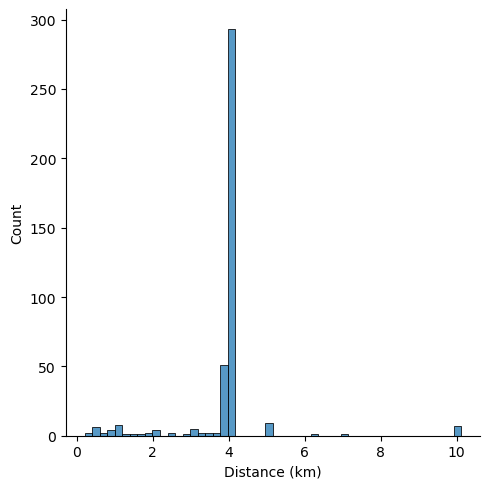

In [4]:
# deleting generic activities
df = df[df['Activity Type'] != 'Generic']

#geting rid of distance less than 0,21 km
df = df[~df['Distance (km)'].between(0, 0.2)]

# let's check what distance appears most often
sns.displot(data=df[df['Activity Type'] == 'Run'], x='Distance (km)', bins=50);

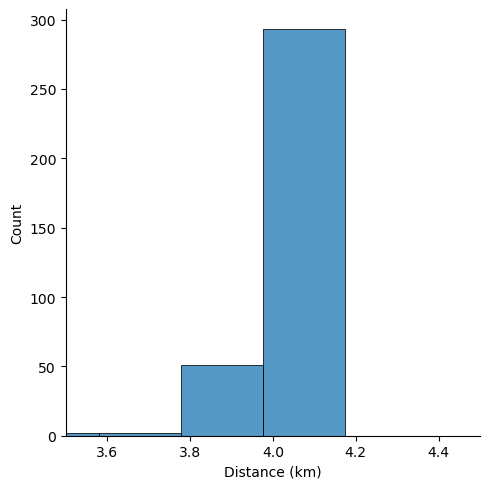

In [5]:
# it is definitely a distance of about 4 km. First goal achieved!
# however, let's take a close look at this
sns.displot(data=df[df['Activity Type'] == 'Run'], x='Distance (km)', bins=50)
plt.xlim(3.5,4.5)
plt.show()

In [6]:
# If it is Run activity type and distance was around 4 km, classify it as 4 km run,
# and calculate the proportional time
df['Workout Time (seconds)'] = np.where((df['Distance (km)'].between(3.9,4.10) & (df['Activity Type'] == 'Run')),
         ((df['Workout Time (seconds)'] *4) / df['Distance (km)']).astype(int),
         df['Workout Time (seconds)'])

df['Distance (km)'] = np.where((df['Distance (km)'].between(3.9,4.10) & (df['Activity Type'] == 'Run')),
                               4, df['Distance (km)'])

# correct avarage pace
df['Avg Pace (min/km)'] = ((df['Workout Time (seconds)'] / 60) / df['Distance (km)']).round(2)

# correct avarage speed
df['Avg Speed (km/h)'] = (df['Distance (km)'] / (df['Workout Time (seconds)'] / 3600)).round(2)

# extract only 4 km runs
df = df[(df['Activity Type'] == 'Run') & (df['Distance (km)'] == 4)]

# drop unnecessary columns
df = df.drop(columns=['Calories Burned (kCal)', 'Activity Type', 'Distance (km)'])

# this is how df looks now
df

,Workout Date,Workout Time (seconds),Avg Pace (min/km),Avg Speed (km/h)
0,"Oct. 5, 2023",1059,4.41,13.60
9,"Oct. 1, 2023",1037,4.32,13.89
15,"Sept. 26, 2023",1040,4.33,13.85
21,"Sept. 21, 2023",1044,4.35,13.79
26,"Sept. 17, 2023",1051,4.38,13.70
...,...,...,...,...
1171,"Aug. 24, 2017",1171,4.88,12.30
1173,"Aug. 23, 2017",1202,5.01,11.98
1174,"Aug. 22, 2017",1177,4.90,12.23
1198,"Sept. 2, 2016",1181,4.92,12.19


### 2. visualising the average time in specific periods

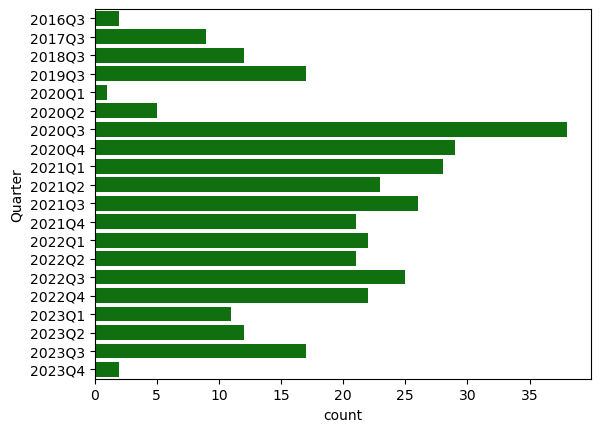

In [7]:
# let's say we are interested in the average time in individual quarters

# let's copy the df for visualisation purposes
df_vis = df.copy()

# changing Workout Date to a datetime object
df_vis['Workout Date'] = pd.to_datetime(df_vis['Workout Date'])

# inserting a new column that shows what year-quarter each training belongs to
df_vis['Quarter'] = df_vis['Workout Date'].dt.to_period('Q')

# checking the number of 4 km runs in individual quarters
sns.countplot(data=df_vis.sort_values(by='Quarter'), y='Quarter', color='green')
plt.show()

In [8]:
# analysing the plot above we can say that frequent and regular 4km runs started in Q3-2020

# hence, let's delete all runs before Q3-2020
df_vis = df_vis[df_vis['Quarter'] >= '2020Q3']

#Additionally, since data for the current quarter may be incomplete,
# we are excluding the current quarter from our analysis
df_vis = df_vis[df_vis['Quarter'] < pd.to_datetime('today').to_period('Q')]

# our dataframe looks like this now:
df_vis

,Workout Date,Workout Time (seconds),Avg Pace (min/km),Avg Speed (km/h),Quarter
15,2023-09-26,1040,4.33,13.85,2023Q3
21,2023-09-21,1044,4.35,13.79,2023Q3
26,2023-09-17,1051,4.38,13.70,2023Q3
29,2023-09-14,1074,4.47,13.41,2023Q3
35,2023-09-11,1077,4.49,13.37,2023Q3
...,...,...,...,...,...
1051,2020-07-12,1142,4.76,12.61,2020Q3
1058,2020-07-08,1169,4.87,12.32,2020Q3
1062,2020-07-06,1192,4.97,12.08,2020Q3
1065,2020-07-04,1183,4.93,12.17,2020Q3


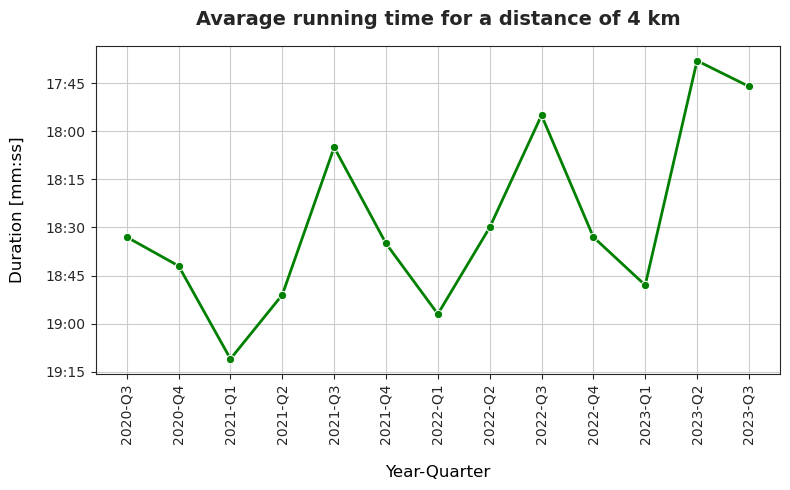

In [9]:
# as we will want to show the average running time in individual quarters in our visualization,
# let's use the groupby to get the proper values
df_vis = df_vis.groupby(df_vis['Workout Date'].dt.to_period('Q'))['Workout Time (seconds)'].mean().reset_index()

# let's change Workout Time to integers
df_vis['Workout Time (seconds)'] = df_vis['Workout Time (seconds)'].astype(int)

# convert seconds to minutes
df_vis['Workout Time (seconds)'] = pd.to_datetime(df_vis['Workout Time (seconds)'], unit='s')

# and change format of the Quarter column
df_vis['Workout Date'] = df_vis['Workout Date'].dt.strftime('%Y-Q%q')

# now let's get on with the chart"
sns.set_style('ticks')

# create the line plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_vis, x='Workout Date', y='Workout Time (seconds)',
             color='green', linewidth=2, marker='o', linestyle='-')

# set the title
plt.title('Avarage running time for a distance of 4 km', fontsize=14, fontweight='bold', pad=15)

# set the date formatter for the y-axis
formatter = mdates.DateFormatter('%M:%S')
plt.gca().yaxis.set_major_formatter(formatter)

# invert the y-axis
plt.gca().invert_yaxis()

# set labels and rotation for x-axis
plt.xlabel('Year-Quarter', fontsize=12, labelpad=15, color='black')
plt.ylabel('Duration [mm:ss]', fontsize=12, labelpad=15, color='black')
plt.xticks(rotation=90)

# display the grid
plt.grid(True)

# adjust layout
plt.tight_layout()

# show the plot
plt.show()

In [10]:
# it looks very good. 2nd objective achieved!

# conclusion: it is highly probable that the trainee ran in a moderate climate
# and was subject to seasonality because he achieved the worst results in the cold months ;)

### 3.  identifying the 10 best results

In [11]:
# let's recal what our df looks like
df.head()

,Workout Date,Workout Time (seconds),Avg Pace (min/km),Avg Speed (km/h)
0,"Oct. 5, 2023",1059,4.41,13.60
9,"Oct. 1, 2023",1037,4.32,13.89
15,"Sept. 26, 2023",1040,4.33,13.85
21,"Sept. 21, 2023",1044,4.35,13.79
26,"Sept. 17, 2023",1051,4.38,13.70


In [12]:
# creating a copy of df
best_results = df.copy()

# creating a new column based on Workout Time: Duration [mm:ss]
best_results['Duration [mm:ss]'] = best_results[
    'Workout Time (seconds)'].apply(lambda x: f'{x // 60:02}:{x % 60:02}')

# Correct the format of Avg Pace
best_results['Avg Pace (min/km)'] = best_results[
    'Avg Pace (min/km)'].apply(lambda x: f"{int(x)}:{int((x - int(x)) * 60):02d}")

# sorting dataframe by workout time
best_results = best_results.sort_values(by='Workout Time (seconds)')

# let's rank each result. Add value in Rank columns
best_results['Rank'] = best_results['Workout Time (seconds)'].rank(method='dense', ascending=True).astype(int)

# we're limiting our dataframe to the top 10 results and leaving only necessary columns
best_results = best_results[best_results['Rank'] <= 10][[
    'Rank', 'Workout Date', 'Duration [mm:ss]', 'Avg Pace (min/km)', 'Avg Speed (km/h)']].reset_index(drop=True)


# here are the 10 best 4km run results
best_results

,Rank,Workout Date,Duration [mm:ss],Avg Pace (min/km),Avg Speed (km/h)
0,1,"June 4, 2023",17:05,4:16,14.05
1,1,"May 25, 2023",17:05,4:16,14.05
2,2,"Oct. 1, 2023",17:17,4:19,13.89
3,3,"Sept. 26, 2023",17:20,4:19,13.85
4,4,"July 22, 2023",17:22,4:20,13.82
5,4,"June 21, 2022",17:22,4:20,13.82
6,5,"July 27, 2023",17:23,4:20,13.81
7,5,"June 15, 2023",17:23,4:20,13.81
8,6,"Sept. 21, 2023",17:24,4:20,13.79
9,7,"July 12, 2023",17:25,4:20,13.78


### All 3 goals achieved!